In [40]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import os
import seaborn as sns
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
import pims
import pySPM as spm 
import trackpy as tp
import glob
from sxmreader import SXMReader
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
import sklearn
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Use Trackpy to read in tracks
t3 gets multiplied by NM_PER_PIXEL entirely at some point - messes with non x-y values so use t2 for plotting

Frame 88: 124 trajectories present.


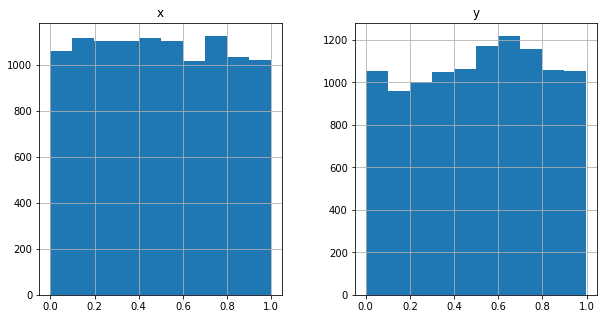

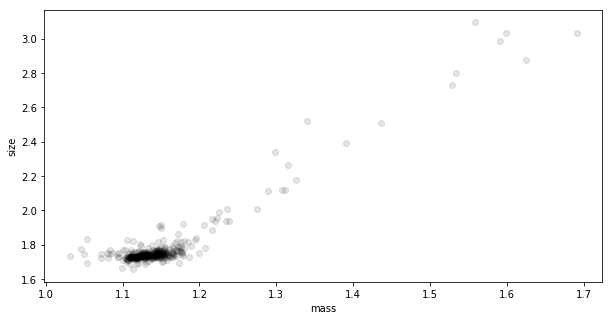

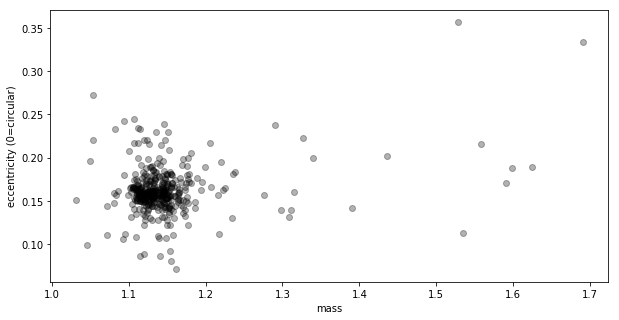

Before: 405
After: 405
bad: [4.6875, 5.208333333333334, 12.5, 13.020833333333334, 20.833333333333336, 26.562500000000004, 27.604166666666668, 31.250000000000004, 33.85416666666667, 34.895833333333336, 35.9375, 36.458333333333336, 40.10416666666667, 41.66666666666667, 44.79166666666667, 46.35416666666667, 47.395833333333336, 48.4375, 50.0, 51.56250000000001, 62.50000000000001, 70.83333333333334, 72.39583333333334, 79.6875, 87.5, 92.1875, 94.27083333333334, 95.83333333333334, 98.4375, 98.95833333333334, 109.89583333333334, 111.45833333333334, 114.58333333333334, 119.27083333333334, 122.39583333333334, 129.6875, 131.25, 137.5, 139.58333333333334, 144.79166666666669, 160.9375, 168.22916666666669, 174.47916666666669]
good: [0.0, 0.5208333333333334, 1.0416666666666667, 1.5625, 2.0833333333333335, 2.604166666666667, 3.125, 3.6458333333333335, 4.166666666666667, 5.729166666666667, 6.25, 6.770833333333334, 7.291666666666667, 7.812500000000001, 8.333333333333334, 8.854166666666668, 9.375, 9.8958

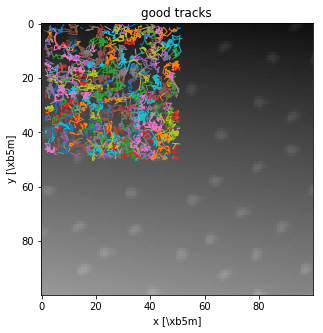

              0.000000    0.520833    1.041667    1.562500    2.083333    \
lag time [s]                                                               
1.0             0.504998    0.408498    0.541660    0.478092    1.439500   
2.0             0.814761    0.878932    0.862083    1.118950    3.228331   
3.0             1.056660    1.329692    1.135817    1.589197    4.901318   
4.0             1.427045    1.658888    1.355196    1.794166    6.286330   
5.0             1.649124    1.876493    1.462973    1.917639    8.220186   
...                  ...         ...         ...         ...         ...   
83.0                 NaN         NaN         NaN         NaN  273.508087   
84.0                 NaN         NaN         NaN         NaN  285.410918   
85.0                 NaN         NaN         NaN         NaN  307.293672   
86.0                 NaN         NaN         NaN         NaN  323.196763   
87.0                 NaN         NaN         NaN         NaN  331.694292   

           

In [44]:
# n_range = range(372, 510)
# n_range = range(29, 353)


n_range = range(428, 517) ##em_18
# n_range = range(600,750) ##em_26
# n_range = range(750, 850) ##em_26
N = len(n_range)
SXM_PATH = ["electromigration_18/Image_{0:03}.sxm".format(i) for i in n_range]
frames = SXMReader(SXM_PATH)
molecule_size = 11
min_mass = 1
max_mass = 5
min_size = 1
max_size = 5
max_ecc = 0.5
separation = 5
searchRange = 30


f = tp.batch(frames[:], molecule_size, minmass=min_mass, separation=separation)
tp.subpx_bias(f)


t = tp.link(f, search_range=searchRange, adaptive_stop=10, memory=1)
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass


t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) & (t['size'] < max_size) &
         (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
t2 = tp.filter_stubs(t, 1)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())


d = tp.compute_drift(t2)
t3 = tp.subtract_drift(t2.copy(), d)
# print(d)




from scipy.stats import norm
NM_PER_PIXEL = frames.meters_per_pixel*1e9
d = tp.compute_drift(t2)
t3 = tp.subtract_drift(t2.copy(), d) * NM_PER_PIXEL
t3 = t3.drop(columns='frame').reset_index()
t3['x_inc'] = t3.groupby('particle')['x'].diff()
t3 = t3[~t3['x_inc'].isna()]


NM_PER_PIXEL = frames.meters_per_pixel * 1e9


good_particles = []
bad_particles = []
t4 = t3.groupby('particle').filter(lambda x: len(x) >= 2)
paths = []
def is_track_good(track):
    global displacements
    x = track['x'].values
    y = track['y'].values
    denan = lambda x: x[~np.isnan(x)]
    x = denan(x) 
    y = denan(y) 
    pos = np.array([x,y]).T
    delta = pos[1:]-pos[:-1]
    mean_square = np.einsum("ij, ij->i", delta, delta)
    good = np.max(mean_square) < (3e-9/frames.meters_per_pixel)**2
    if good:
        good_particles.append(track['particle'].values[0])
    else:
        bad_particles.append(track['particle'].values[0])
    if(good):
        paths.append(delta)
    return good 
tm = t4.groupby('particle').filter(is_track_good)
# tm = t3
print("bad:", bad_particles)
plt.figure()
plt.title("bad tracks")
# tp.plot_traj(t4.groupby('particle').filter(lambda x: not is_track_good(x)), mpp=(frames.meters_per_pixel*1e6), superimpose=frames[0]);
print("good:", good_particles)
plt.title("good tracks")
tp.plot_traj(tm, mpp=(frames.meters_per_pixel*1e9), superimpose=frames[0]);
im = tp.imsd(tm, 1e9*frames.meters_per_pixel, 1)  # microns per pixel = 100/285., frames per second = 24
# im = im.T[movement_filter].T 
print(im)

## Machine Learning Prediction

In [42]:
def classification_on_real(dx, steps=50,fbm=False):
    N=np.shape(dx)[0]
    net_file = 'models/{}_new_model.h5'.format(steps)
    model = load_model(net_file)
    ##alpha_model = load_model('88_alpha_model.h5')
    
    if fbm:
        fbm_model = load_model('models/{}_fbm_alpha.h5'.format(steps))
    
    predictions = []
    values = []
    for j in range(N):
        dummy = np.zeros((1,steps-1,1))
        dummy[0,:,:] = np.reshape(dx[j,:], (steps-1, 1))
        y_pred = model.predict(dummy) # get the results for 1D 
        ##alpha_pred = alpha_model.predict(dummy)
        ymean = np.mean(y_pred,axis=0) # calculate mean prediction of N-dimensional trajectory 
        values.append(ymean.round(decimals=2))
        prediction = np.argmax(ymean,axis=0) # translate to classification
        predictions.append((j, prediction))
        ##print('y_pred {}'.format(y_pred))
        ##print('prediction {}'.format(prediction))
        ##print('alpha {}'.format(alpha_pred))
        if fbm and prediction == 0:
            fbm_alpha_pred = fbm_model.predict(dummy)
          ##print('fbm_coef {}'.format(fbm_alpha_pred))
    return values, predictions

def get_activations(dx, steps=50,fbm=False):
    N=np.shape(dx)[0]
    net_file = 'models/{}_new_model.h5'.format(steps)
    model = load_model(net_file)

    layer_name = 'concatenate_1'
    intermediate_layer_model = keras.Model(inputs=model.input,
                                     outputs=model.get_layer(layer_name).output)
    
    activations = []
    values = []
    for j in range(N):
        dummy = np.zeros((1,steps-1,1))
        dummy[0,:,:] = np.reshape(dx[j,:], (steps-1, 1))
        
        activations.append(intermediate_layer_model.predict(dummy)) # get the results for 1D
        
    return activations
def generate_dx(x):
    temp_x = x-np.mean(x)
    dx = np.diff(temp_x)
    dx = dx/np.std(dx)
    return dx

In [43]:
steps = 50
long_paths = [x[:steps,1] for x in paths if x.shape[0] >= steps]
x1 = np.array(long_paths)
x1 = x1-np.mean(x1)
x_n = x1
dx = np.diff(x_n)
dx = dx/np.std(dx)
values, predictions = classification_on_real(dx)
activations = np.array(get_activations(dx))
activations = activations.reshape((activations.shape[0], activations.shape[2]))

## Data and Error Analysis

### TODOS:
#### Data analysis
* generate artificial data and visualize to see stronger trends
* test confusion matrix using artificial data
* test pca on real data?
* test t-SNE on artificial data

#### Temperature changing
* figure out what values to change to simulate changing temperature

### T-SNE
#### Notes
* There doesn't seem to be an extremely strong trend in the data? This sample may have been bad

In [45]:
from sklearn.manifold import TSNE

In [54]:
def tsne(dx, predictions, s=30, ax=None, markers = ["o",">","s"], color="tab:blue", fbm_coeffs=None, ctrw_alphas=None):
    embedded_dx = TSNE(init="pca", random_state=12345).fit_transform(dx)

    fbm_points = np.array([x for idx, x in enumerate(embedded_dx) if predictions[idx][1] == 0])
    ctrw_points = np.array([x for idx, x in enumerate(embedded_dx) if predictions[idx][1] == 2])
    brownian_points = np.array([x for idx, x in enumerate(embedded_dx) if predictions[idx][1] == 1])

    fbm = None
    ctrw = None
    brownian = None
    plt_list = []
    plt_names = []
    if ax is None:
        ax = plt.axes()
        ax.figure.set_size_inches(12,8)
    if fbm_points.size != 0:
        if fbm_coeffs is not None:
            cmap = sns.cubehelix_palette(as_cmap=True)
            fbm = ax.scatter(fbm_points[:,0], fbm_points[:,1], s=s, 
                             c=fbm_coeffs*2,marker=markers[0], edgecolors='black',cmap=cmap)
        else:
            fbm = ax.scatter(fbm_points[:,0], fbm_points[:,1], s=s, c=color,marker=markers[0], edgecolors='black')
        plt_list.append(fbm)
        plt_names.append("fbm")
    if ctrw_points.size != 0:
        if ctrw_alphas is not None:
            cmap = sns.cubehelix_palette(as_cmap=True, rot=-0.4)
            ctrw = ax.scatter(ctrw_points[:,0], ctrw_points[:,1], s=s, 
                              c=ctrw_alphas, marker=markers[1], edgecolors='black', cmap=cmap)
        else:
            ctrw = ax.scatter(ctrw_points[:,0], ctrw_points[:,1], s=s, c=color, marker=markers[1], edgecolors='black')
        plt_list.append(ctrw)
        plt_names.append("ctrw")
    if brownian_points.size != 0:
        brownian = ax.scatter(brownian_points[:,0], brownian_points[:,1], s=s, c=color, marker=markers[2],edgecolors='black')
        plt_list.append(brownian)
        plt_names.append("brownian")

    plt.legend(plt_list, plt_names)
    return ctrw, ax

(<matplotlib.collections.PathCollection at 0x7fbad9ac8e80>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fbad9fff1d0>)

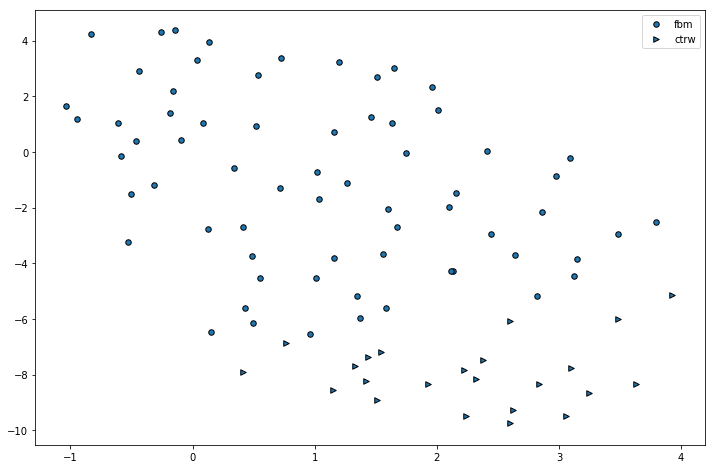

In [55]:
tsne(activations, predictions)
# plt.title("TSNE on em18 data activations")

## Visualize Frames

In [9]:
classified_particles = [good_particles[index] for index, x in enumerate(paths) if x.shape[0] >= steps]
classified_particles = (np.array(classified_particles) / NM_PER_PIXEL).astype(int)
particle_to_classification = {}
for pred in predictions:
    particle_to_classification[classified_particles[pred[0]]] = pred[1]


In [10]:
frame = 70
frame_classified = t2[t2["particle"].isin(classified_particles)]

frame_classified = frame_classified[frame_classified["frame"]==frame]
frame_classified["classification"] = [particle_to_classification[particle] for particle in frame_classified["particle"]]
len(frame_classified)

45

<Figure size 432x288 with 0 Axes>

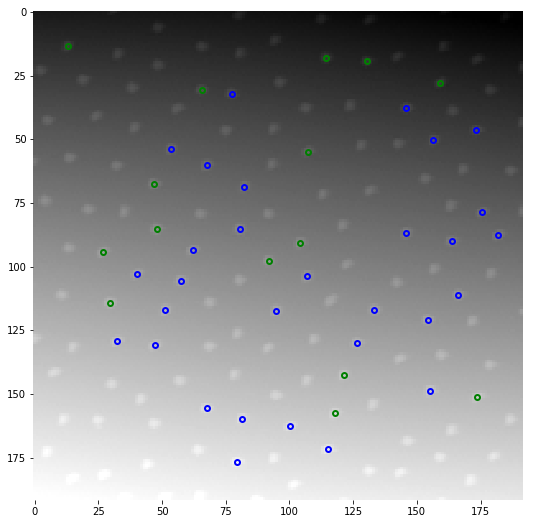

In [11]:
plt.figure()
fig=plt.figure(figsize=(12, 9))
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
ln, = ax1.plot([], [], lw=3)
colors = ["b", "g" ]
tp.annotate(frame_classified, frames[frame],color=colors, split_category="classification", split_thresh=1, plot_style={'markersize': 5}, ax=ax1)


##blue == 0 and green == 2 --> blue is FBM and green is CTRW

<Figure size 720x720 with 0 Axes>

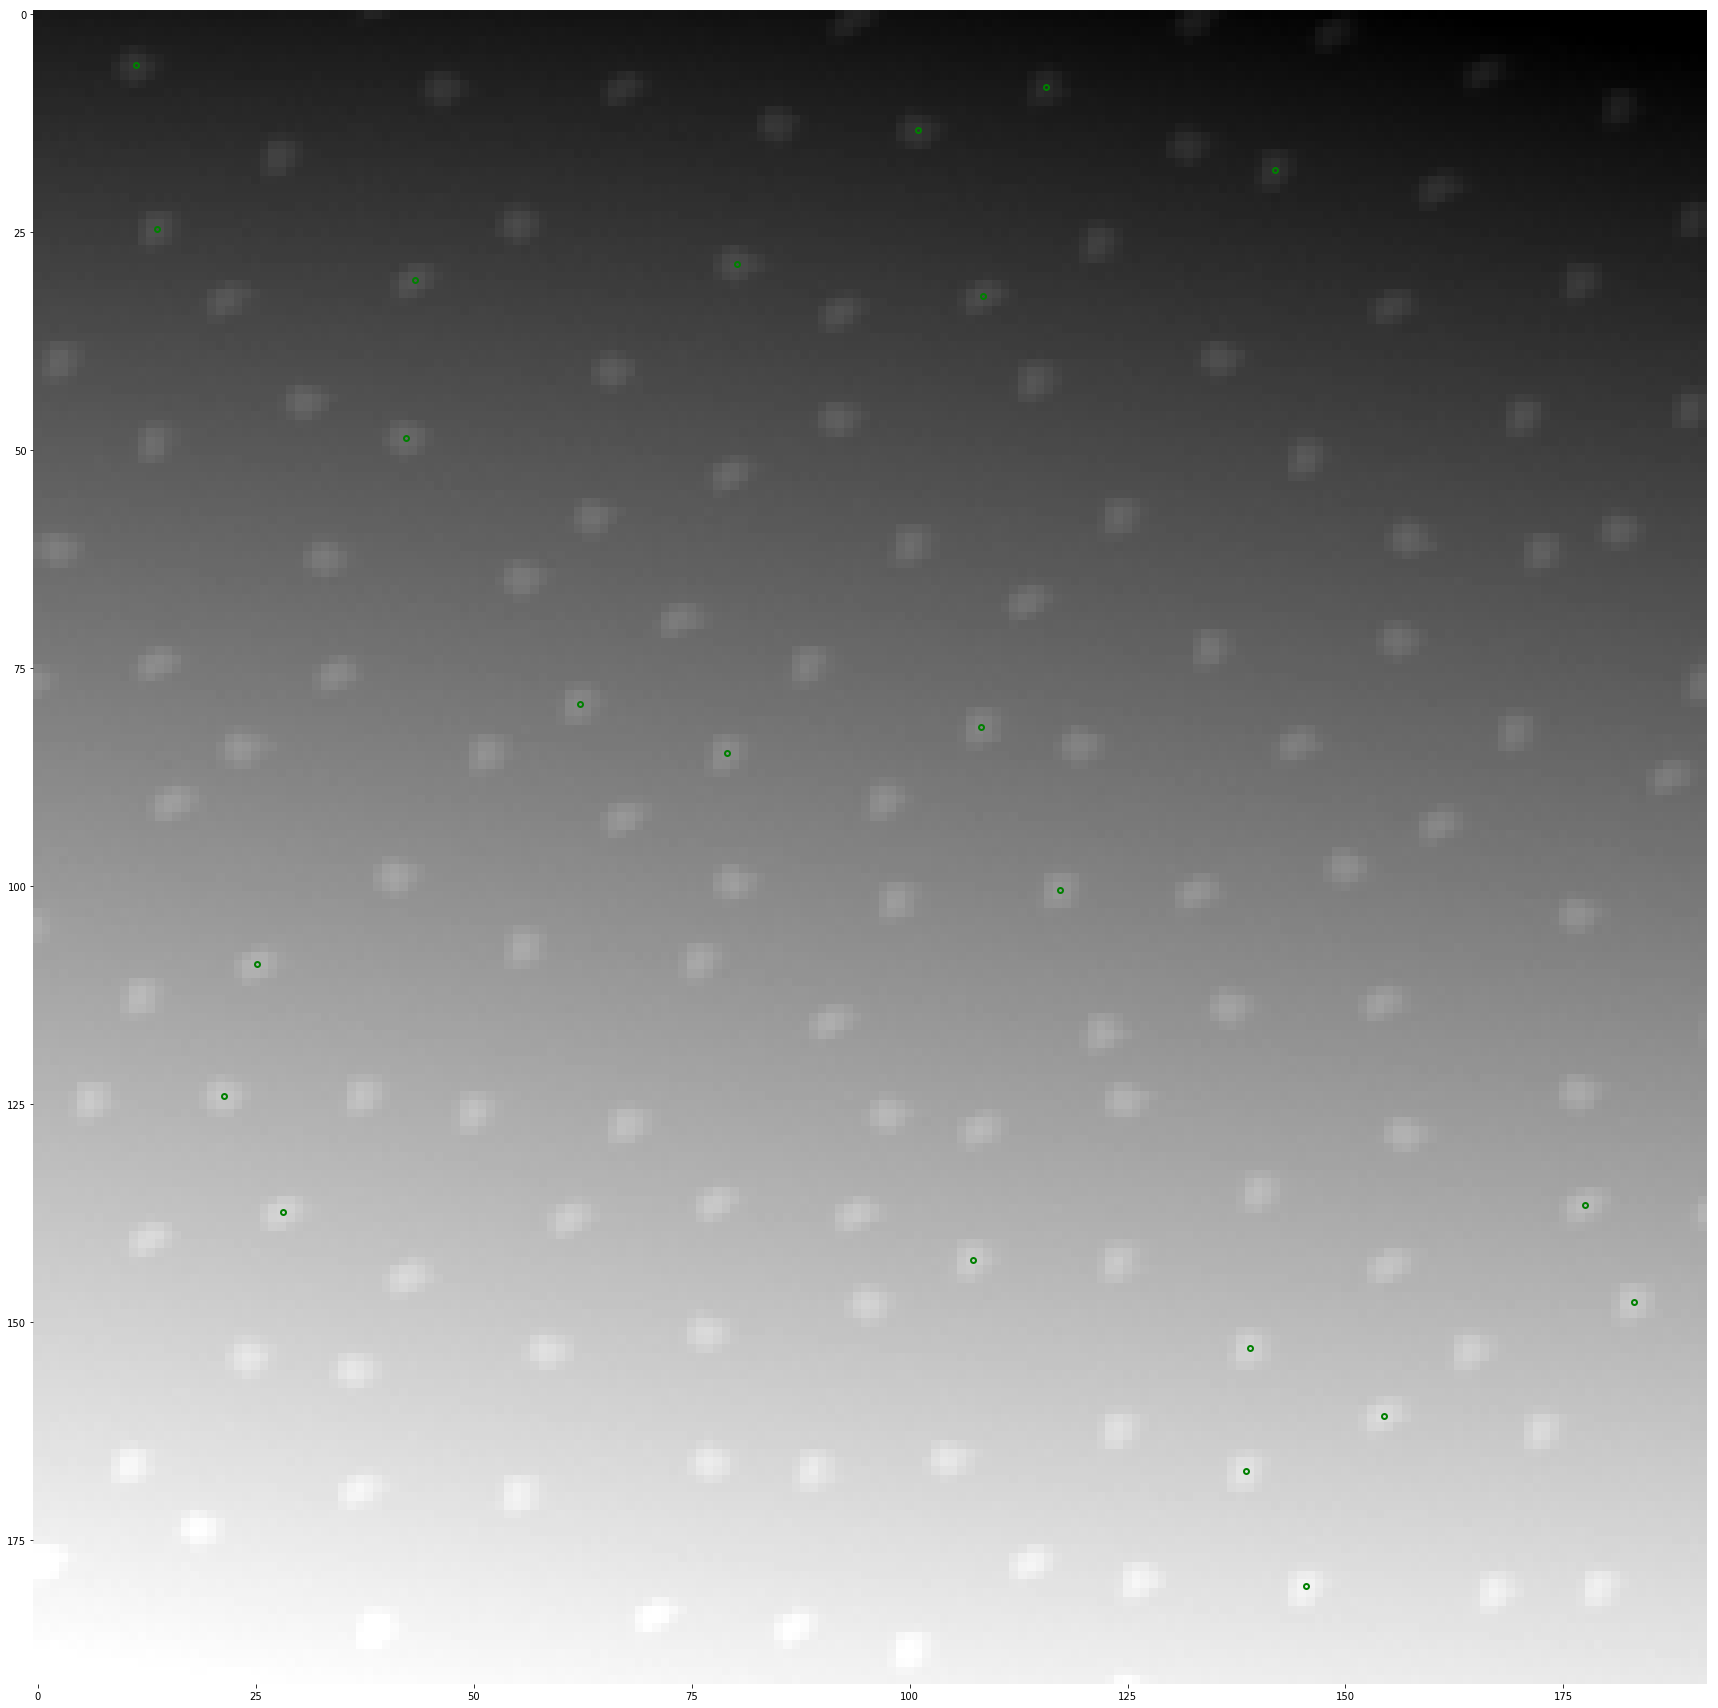

In [68]:
plt.figure(figsize=(10,10))

fig=plt.figure(figsize=(30, 40))
ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
ln, = ax1.plot([], [], lw=3)
# plt.axis('off')

def update(i):
    frame = i
    frame_classified = t2[t2["particle"].isin(classified_particles)]

    frame_classified = frame_classified[frame_classified["frame"]==frame]
    frame_classified["classification"] = [particle_to_classification[particle] for particle in frame_classified["particle"]]
    len(frame_classified)
    tp.annotate(frame_classified, frames[frame],color=colors, split_category="classification", split_thresh=1, plot_style={'markersize': 5}, ax=ax1)

#     tp.annotate(f[f['frame']==i], frames[i],  plot_style={'markersize': 0.5}, ax=ax1)
#     tp.annotate(f[f['frame']==i], frames[i],  plot_style={'markersize': 0,5}, ax=ax1)
    for line in ax1.lines[:-1]:
        line.set_marker(None)
    return ln,

ani = FuncAnimation(fig, update, frames=range(len(frames)), interval=100)
ani

## Temperature Experiments
If Moire not specified in file it's 45!

In [48]:
temperatures = np.linspace(1e-2, 5e-1, 20)

all_temp_activations = []
all_temp_predictions = []
all_temp_values = []
num_fbm = []
num_brownian = []
num_ctrw = []

for temp in temperatures:
    with open('sim_results/len50temp{}_1m.npy'.format(temp), 'rb') as f:
        x = np.load(f)
        y = np.load(f)
    temp_x = x-np.mean(x)
    temp_dx = np.diff(temp_x)
    temp_dx = temp_dx/np.std(temp_dx)

    temp_values, temp_predictions = classification_on_real(temp_dx)
    all_temp_activations.append(get_activations(temp_dx))
    
    num_fbm.append(sum([1 for idx, x in temp_predictions if x == 0]))
    num_brownian.append(sum([1 for idx, x in temp_predictions if x == 1]))
    num_ctrw.append(sum([1 for idx, x in temp_predictions if x == 2]))
    
    all_temp_predictions.append(temp_predictions)
    all_temp_values.append(temp_values)

all_temp_activations = np.array(all_temp_activations)

less monte carlo steps -> the std dev of the displacement between jumps should be lower relative to mean -> when normalized the model is more sensitive to smaller displacement -> so it's more likely to classify smaller displacement as brownian rather than some of them staying ctrw? not sure if this logic works exactly with taking more steps and evenly sampling and how that affects the distribution of displacements, but the model definitely classifies ctrw less

Text(0.5, 1.0, 'Temperature vs Proportion of Class (simulated data 100k monte carlo 10 moire)')

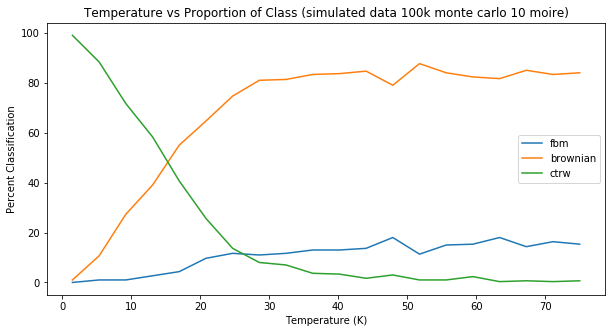

In [49]:
x = np.linspace(1e-2, 5e-1, 20) * 150
plt.plot(x, np.array(num_fbm) / 3, c="tab:blue",label="fbm")
plt.plot(x, np.array(num_brownian) / 3, c="tab:orange", label="brownian")
plt.plot(x, np.array(num_ctrw) / 3, c="tab:green",label="ctrw")
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Percent Classification")
plt.title("Temperature vs Proportion of Class (simulated data 100k monte carlo 10 moire)")

### TSNE Temperature Activations


In [51]:
all_temp_activations = all_temp_activations.reshape((all_temp_activations.shape[0], 
                                                     all_temp_activations.shape[1],
                                                     all_temp_activations.shape[3]))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

Text(0.5, 1.0, 'TSNE temperature sim 1k monte carlo')

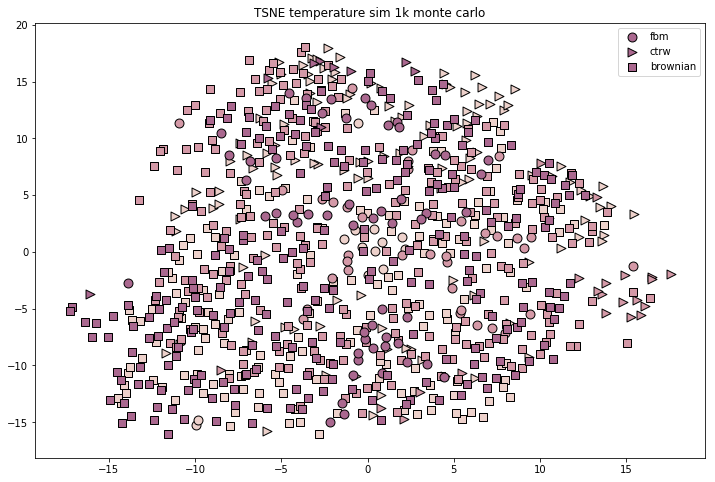

In [56]:
marker_size = 80
colors = sns.cubehelix_palette(9)
ctrw1, ax = tsne(all_temp_activations[4], all_temp_predictions[4], s = marker_size, color=colors[0])
ctrw2, ax = tsne(all_temp_activations[8], all_temp_predictions[8], s = marker_size, ax=ax, color=colors[2])
ctrw3, ax = tsne(all_temp_activations[12], all_temp_predictions[12], s = marker_size, ax=ax, color=colors[4])
# ctrw4, ax = tsne(all_temp_activations[16], all_temp_predictions[16], s = marker_size, ax=ax, color=colors[6])
# ctrw4, ax = tsne(all_temp_activations[19], all_temp_predictions[19],s = marker_size,  ax=ax, color=colors[8])

# marker_legend = plt.legend([ctrw1, ctrw2],labels =["4","8"])
# ax = plt.gca().add_artist(marker_legend)
plt.title("TSNE temperature sim 1k monte carlo")

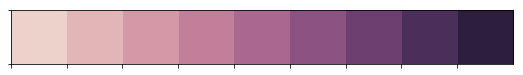

In [239]:
sns.palplot(colors)

### TSNE Vida Sim

In [215]:
with open('sim_track50.npy', 'rb') as f:
    vida_tracks = np.load(f)
    vida_labels = np.load(f)
    vida_labels = vida_labels.argmax(axis=1)
    vida_labels = [(i,x) for i, x in enumerate(vida_labels)]
with open('sim_track50_coeffs.npy', 'rb') as f:
    ctrw_alphas = np.load(f)
    fbm_coeffs = np.load(f)

In [188]:
vida_values, vida_preds = classification_on_real(vida_tracks)

In [195]:
vida_activations = np.array(get_activations(vida_tracks))

In [199]:
vida_activations = vida_activations.reshape((vida_activations.shape[0], 
                                                     vida_activations.shape[2]))

In [217]:
ctrw_track_inds = [i for i, x in enumerate(vida_labels) if x[1] == 2]
fbm_track_inds = [i for i, x in enumerate(vida_labels) if x[1] == 0]

Text(0.5, 1.0, "Actual Class and Actual Alpha value t-SNE for Vida's Sim")

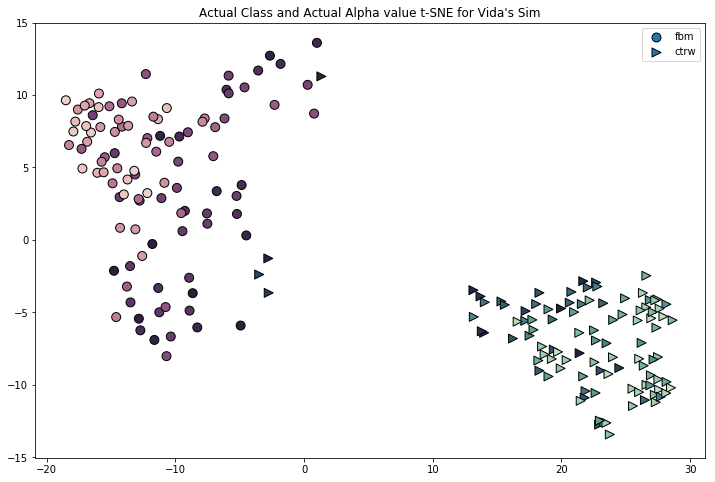

In [249]:
tsne(vida_activations, vida_labels, s = marker_size, fbm_coeffs=fbm_coeffs, ctrw_alphas=ctrw_alphas)
plt.title("Actual Class and Actual Alpha value t-SNE for Vida's Sim")

## Filter Visualization

In [57]:
net_file = 'models/50_new_model.h5'
model = load_model(net_file)

In [58]:
model.layers[1]


In [59]:
conv_layers = [x for x in model.layers if isinstance(x, keras.layers.Conv1D)]



In [60]:
[print(x.get_weights()[0].shape) for x in conv_layers]

(2, 1, 32)
(2, 1, 32)
(3, 1, 32)
(3, 1, 32)
(4, 1, 32)
(2, 32, 32)
(2, 32, 32)
(3, 32, 32)
(3, 32, 32)
(4, 32, 32)
(2, 32, 32)
(2, 32, 32)
(3, 32, 32)
(3, 32, 32)
(4, 32, 32)
(3, 1, 32)


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [66]:
conv_layers[-5].output_shape

(None, 49, 32)

In [64]:
all_temp_activations.shape

(20, 300, 192)

In [65]:
all_temp_values

[[array([0.05, 0.09, 0.86], dtype=float32),
  array([0.07, 0.17, 0.77], dtype=float32),
  array([0.01, 0.03, 0.96], dtype=float32),
  array([0.02, 0.07, 0.92], dtype=float32),
  array([0.02, 0.04, 0.94], dtype=float32),
  array([0.  , 0.01, 0.98], dtype=float32),
  array([0.  , 0.01, 0.99], dtype=float32),
  array([0., 0., 1.], dtype=float32),
  array([0.  , 0.  , 0.99], dtype=float32),
  array([0.  , 0.01, 0.98], dtype=float32),
  array([0.01, 0.04, 0.96], dtype=float32),
  array([0.  , 0.01, 0.99], dtype=float32),
  array([0.05, 0.11, 0.84], dtype=float32),
  array([0., 0., 1.], dtype=float32),
  array([0., 0., 1.], dtype=float32),
  array([0.01, 0.13, 0.86], dtype=float32),
  array([0., 0., 1.], dtype=float32),
  array([0.02, 0.06, 0.92], dtype=float32),
  array([0.01, 0.02, 0.97], dtype=float32),
  array([0.05, 0.11, 0.84], dtype=float32),
  array([0.  , 0.01, 0.99], dtype=float32),
  array([0.02, 0.04, 0.95], dtype=float32),
  array([0.  , 0.01, 0.99], dtype=float32),
  array([0.0